In [21]:
from pathlib import Path
path_to_data_notebook = Path.cwd().parent.parent.parent / "Data" / "1_Preprocesed_data.ipynb"
%run {path_to_data_notebook}

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import datetime 
import time
from sklearn.model_selection import train_test_split

/home/pc/moje/python_projects/adsorbents_isotherms/Data/all_data.csv
------------------------------- Preprocessing_data start -------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Article_name                    1011 non-null   object 
 1   Figure_number                   1011 non-null   object 
 2   Sample_name                     1011 non-null   object 
 3   Total_surface_area[m2/g]        928 non-null    float64
 4   Total_pore_volume[cm3/g]        778 non-null    float64
 5   Micropore_volume[cm3/g]         730 non-null    float64
 6   Mesopore_volume[cm3/g]          21 non-null     float64
 7   Average_pore_diameter[nm]       121 non-null    float64
 8   Impregnation_ratio[agent/char]  20 non-null     float64
 9   Activation_type                 33 non-null     object 
 10

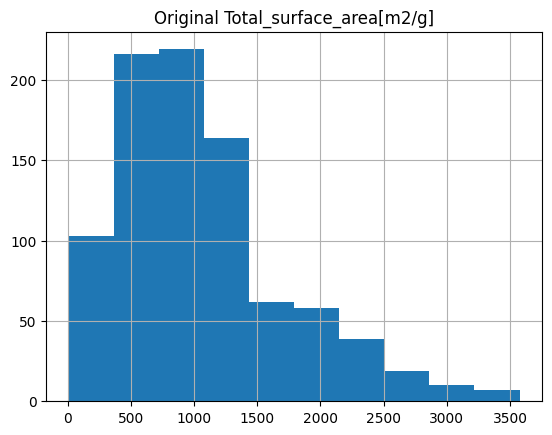

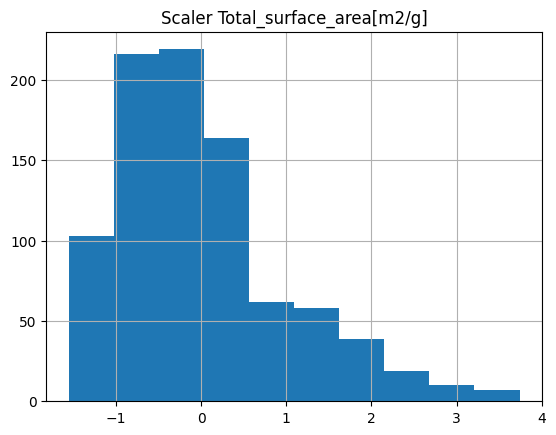

X_train size = 879
y_train size = 879
X_test size = 18
y_test size = 18


In [22]:
size = 35
x_range_to_cut = 0.001
df = get_whole_preprocessed_dataframe(size, x_range_to_cut)
# choosen property for y:
choosen_property_1 = "Total_surface_area[m2/g]"

# ------------------------------- scaler
df[choosen_property_1].hist()
plt.title(f"Original {choosen_property_1}")
plt.show()
output_scaler = StandardScaler()
df[choosen_property_1] = output_scaler.fit_transform(df[[choosen_property_1]])
df[choosen_property_1].hist()
plt.title(f"Scaler {choosen_property_1}")
plt.show()
# ------------------------------- scaler

df_with_data = df[df[choosen_property_1].notna()]    # get data if property are present
df_without_data = df[df[choosen_property_1].isna()]    # get data if property arent present

X = df_with_data['processed_flatten_isotherm_X_Y'] # x = 'processed_flatten_isotherm_X_Y'
y = df_with_data # y - temporary all columns for prediction inspection, in next steps we extract only choosen property

X_train, X_test, y_train_nested, y_test_nested, = train_test_split(X, y, test_size=0.02, random_state=42) #random_state=42

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train_nested[choosen_property_1].to_numpy()
y_test = y_test_nested[choosen_property_1].to_numpy() 


scaler = StandardScaler() # only for x data
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

print(f'X_train size = {len(X_train)}')
print(f'y_train size = {len(X_train)}')
print(f'X_test size = {len(X_test)}')
print(f'y_test size = {len(X_test)}')

In [23]:
X_without = df_without_data['processed_flatten_isotherm_X_Y'].tolist()
X_without = scaler.transform(X_without) 
y_without = df_without_data[choosen_property_1].to_numpy()
print(f'X_without size = {len(X_without)}')
print(f'y_without size = {len(y_without)}')

X_without size = 83
y_without size = 83


In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
def calculate_time(transcription_time):
    timedelta_obj = datetime.timedelta(seconds=int(transcription_time))
    return str(timedelta_obj)

In [27]:
epochs_number = 500

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(size, activation='relu'), 
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)                      
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=['mae', 'mse']
model.compile(optimizer=optimizer, loss='mae', metrics=metrics)



# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# history  =  model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)
start = time.time()
history  =  model.fit(X_train, y_train, epochs=epochs_number, batch_size=32, validation_split=0.1, verbose=2)
end = time.time()
transcription_time = calculate_time(round((end - start),2))
print(f"Model training time: "+transcription_time)
model.summary()
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")




Epoch 1/500
25/25 - 2s - 90ms/step - loss: 0.2897 - mae: 0.2897 - mse: 0.2191 - val_loss: 0.1593 - val_mae: 0.1593 - val_mse: 0.0552
Epoch 2/500
25/25 - 0s - 5ms/step - loss: 0.1628 - mae: 0.1628 - mse: 0.0579 - val_loss: 0.1466 - val_mae: 0.1466 - val_mse: 0.0459
Epoch 3/500
25/25 - 0s - 5ms/step - loss: 0.1468 - mae: 0.1468 - mse: 0.0482 - val_loss: 0.1502 - val_mae: 0.1502 - val_mse: 0.0448
Epoch 4/500
25/25 - 0s - 5ms/step - loss: 0.1441 - mae: 0.1441 - mse: 0.0463 - val_loss: 0.1572 - val_mae: 0.1572 - val_mse: 0.0566
Epoch 5/500
25/25 - 0s - 5ms/step - loss: 0.1344 - mae: 0.1344 - mse: 0.0430 - val_loss: 0.1459 - val_mae: 0.1459 - val_mse: 0.0459
Epoch 6/500
25/25 - 0s - 4ms/step - loss: 0.1392 - mae: 0.1392 - mse: 0.0431 - val_loss: 0.1446 - val_mae: 0.1446 - val_mse: 0.0453
Epoch 7/500
25/25 - 0s - 5ms/step - loss: 0.1308 - mae: 0.1308 - mse: 0.0387 - val_loss: 0.1356 - val_mae: 0.1356 - val_mse: 0.0439
Epoch 8/500
25/25 - 0s - 5ms/step - loss: 0.1159 - mae: 0.1159 - mse: 0.033

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 140)            │         5,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         7,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,880 (171.41 KB)

 Trainable params: 14,626 (57.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,254 (114.28 KB)

Metrics: [0.1098371371626854, 0.1098371371626854, 0.019031554460525513]
mae = 0.1098371371626854
mse = 0.019031554460525513


Model training time without gpu, epoch = 1000 : 0:01:10

In [28]:
predictions = model.predict(X_test, verbose=0)
predictions = output_scaler.inverse_transform(predictions)
y_test_scaler = np.array(y_test)
y_test_scaler = y_test_scaler.reshape(-1, 1)
y_test_scaler = output_scaler.inverse_transform(y_test_scaler)

 przewidywana --> [952.64484]     [1041.9] <-- rzeczyswista     blad: [89.25516357]   Data58 5_4 850-45m
 przewidywana --> [457.39056]     [378.] <-- rzeczyswista     blad: [79.39056396]   Data115 1 CAC1900
 przewidywana --> [760.107]     [770.1] <-- rzeczyswista     blad: [9.99300537]   Data58 5_3 800-1h
 przewidywana --> [1495.3175]     [1343.] <-- rzeczyswista     blad: [152.31750488]   Data150 4 10stC
 przewidywana --> [598.5794]     [659.] <-- rzeczyswista     blad: [60.42059326]   Data7 3 RK-600
 przewidywana --> [796.42883]     [817.2] <-- rzeczyswista     blad: [20.77116699]   Data58 5_3 800-1h15m
 przewidywana --> [1355.9171]     [1387.] <-- rzeczyswista     blad: [31.08288574]   Data65 2_2 R2-500
 przewidywana --> [2170.2397]     [2064.] <-- rzeczyswista     blad: [106.23974609]   Data59 2 CMS500
 przewidywana --> [458.39764]     [448.] <-- rzeczyswista     blad: [10.39764404]   Data43 6 F1-8-11
 przewidywana --> [1818.6873]     [1784.] <-- rzeczyswista     blad: [34.68725586

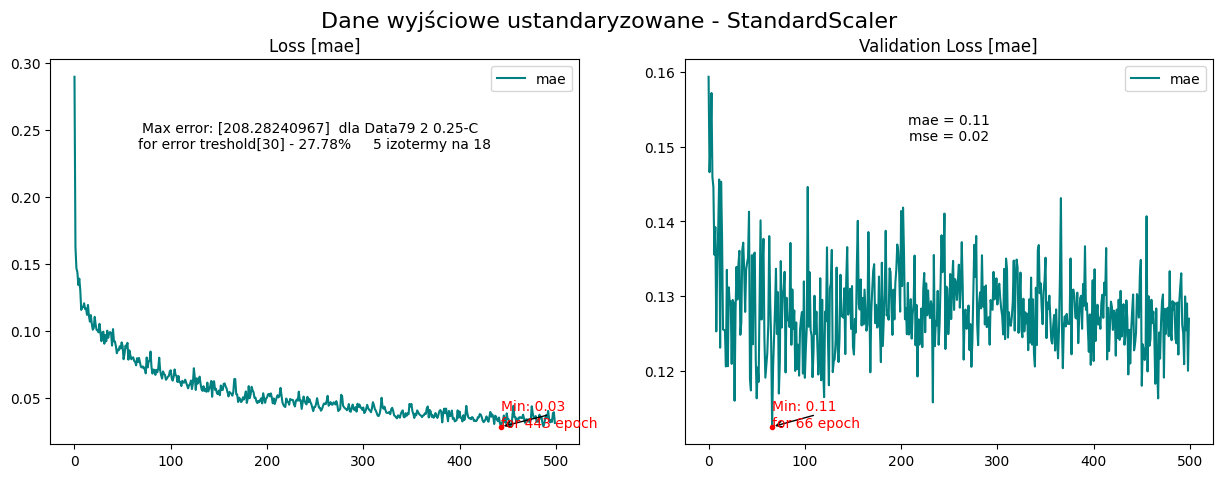

In [29]:
error_threshold = 30
max_error_threshold = 30

list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    data_name = y_test_nested.iloc[i,0]
    graph_number = y_test_nested.iloc[i,1]
    sample_name = y_test_nested.iloc[i,2]
    error = abs(predictions[i] - y_test_scaler[i])
    
    errors.append(error)
    if(error_threshold<=error):
        list_above.append(i)
    else: list_below.append(i)
    print(f" przewidywana --> {predictions[i]}     {y_test_scaler[i]} <-- rzeczyswista     blad: {error}   {data_name} {graph_number} {sample_name}")

    
max_error_index = errors.index(max(errors))
max_error_data_name = y_test_nested.iloc[max_error_index,0]
max_error_graph_number = y_test_nested.iloc[max_error_index,1]
max_error_sample_name = y_test_nested.iloc[max_error_index,2]
text_to_display = f"Max error: {max(errors)}  dla {max_error_data_name} {max_error_graph_number} {max_error_sample_name}  "  + "\n" + f"for error treshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}"




results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
metrics_text = ""
for index, metric in enumerate(metrics):
    metrics_text = metrics_text + f"{metric} = {results[index+1]:.2f}" + "\n"
    print(f"{metric} = {results[index+1]:.2f}")

from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle("Dane wyjściowe ustandaryzowane - StandardScaler ", fontsize=16)

min_loss_idx = history.history['loss'].index(min(history.history['loss']))
min_loss = min(history.history['loss'])# Get the lowest  value
ax[0].plot(history.history['loss'], color='teal', label='mae')
# ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss [mae]')
ax[0].legend()
ax[0].annotate(f'Min: {min_loss:.2f} \nfor {min_loss_idx} epoch', 
               xy=(min_loss_idx, min_loss), 
               xytext=(min_loss_idx  , min_loss ),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[0].plot(min_loss_idx, min_loss, 'ro',markersize=3)# Plot a dot at the minimum point
ax[0].text(0.5, 0.8, text_to_display, horizontalalignment='center', verticalalignment='center',fontsize=10, transform=ax[0].transAxes)

min_val_loss_idx = history.history['val_loss'].index(min(history.history['val_loss']))# Find the index of the minimum 
min_val_loss = min(history.history['val_loss'])# Get the lowest  value
ax[1].plot(history.history['val_loss'], color='teal', label='mae')
# ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Validation Loss [mae]')
ax[1].legend()
# Annotate the lowest point on the validation loss curve
ax[1].annotate(f'Min: {min_val_loss:.2f} \nfor {min_val_loss_idx} epoch', 
               xy=(min_val_loss_idx, min_val_loss), 
               xytext=(min_val_loss_idx , min_val_loss ),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[1].plot(min_val_loss_idx, min_val_loss, 'ro', markersize=3)# Plot a dot at the minimum point
ax[1].text(0.5, 0.8, metrics_text, horizontalalignment='center', verticalalignment='center',fontsize=10, transform=ax[1].transAxes)
# ax[2].plot(history.history['val_mse'], color='teal', label='regress loss')
# # ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# ax[2].title.set_text('Validation mse')
# ax[2].legend()

plt.show()



In [30]:
timestamp = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")
fig.savefig(f'img/3_scaler_{timestamp}.jpg', dpi=100)